In [13]:
# Library imports
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pennylane as qml

# Pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import os

# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [2]:
class DigitsDataset(Dataset):
    """Pytorch dataloader for the Optical Recognition of Handwritten Digits Data Set"""

    def __init__(self, csv_file, label=0, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv_file = csv_file
        self.transform = transform
        self.df = self.filter_by_label(label)

    def filter_by_label(self, label):
        # Use pandas to return a dataframe of only zeros
        df = pd.read_csv(self.csv_file)
        df = df.loc[df.iloc[:, -1] == label]
        return df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.df.iloc[idx, :-1] / 16
        image = np.array(image)
        image = image.astype(np.float32).reshape(8, 8)

        if self.transform:
            image = self.transform(image)

        # Return image and label
        return image, 0

In [15]:
image_size = 8  # Height / width of the square images
batch_size = 1

# transform = transforms.Compose([transforms.ToTensor()]) #Was float64

# Define a custom transformation that converts images to float32 tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.float())  # Convert to float32
])
#Get current directory
current_dir = os.getcwd()
#Define dataset
dataset = DigitsDataset(csv_file=current_dir + "/optical+recognition+of+handwritten+digits/optdigits.tra", transform=transform)

dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, drop_last=True
)



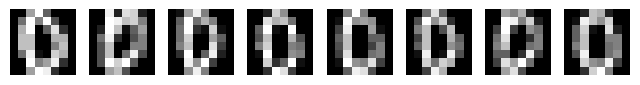

In [16]:
plt.figure(figsize=(8,2))

for i in range(8):
    image = dataset[i][0].reshape(image_size,image_size)
    plt.subplot(1,8,i+1)
    plt.axis('off')
    plt.imshow(image.numpy(), cmap='gray')

plt.show()

In [5]:
class Discriminator(nn.Module):
    """Fully connected classical discriminator"""

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # Inputs to first hidden layer (num_input_features -> 64)
            nn.Linear(image_size * image_size, 64),
            nn.ReLU(),
            # First hidden layer (64 -> 16)
            nn.Linear(64, 16),
            nn.ReLU(),
            # Second hidden layer (16 -> output)
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

In [6]:
# Quantum variables
n_qubits = 5  # Total number of qubits / N
n_a_qubits = 1  # Number of ancillary qubits / N_A
q_depth = 6  # Depth of the parameterised quantum circuit / D
n_generators = 4  # Number of subgenerators for the patch method / N_G


In [7]:
# Quantum simulator
dev = qml.device("lightning.qubit", wires=n_qubits)
# Enable mps device if available
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(device)



mps


/Users/thijs/opt/anaconda3/envs/qml/lib/python3.11/site-packages/pennylane_lightning/lightning_qubit/lightning_qubit.py:824: UserWarning: Pre-compiled binaries for lightning.qubit are not available. Falling back to using the Python-based default.qubit implementation. To manually compile from source, follow the instructions at https://pennylane-lightning.readthedocs.io/en/latest/installation.html.
  warn(


In [8]:
@qml.qnode(dev, diff_method="parameter-shift")
def quantum_circuit(noise, weights):

    weights = weights.reshape(q_depth, n_qubits)

    # Initialise latent vectors
    for i in range(n_qubits):
        qml.RY(noise[i], wires=i)

    # Repeated layer
    for i in range(q_depth):
        # Parameterised layer
        for y in range(n_qubits):
            qml.RY(weights[i][y], wires=y)

        # Control Z gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])

    return qml.probs(wires=list(range(n_qubits)))


# For further info on how the non-linear transform is implemented in Pennylane
# https://discuss.pennylane.ai/t/ancillary-subsystem-measurement-then-trace-out/1532
# def partial_measure(noise, weights):
#     # Ensure noise and weights are on the correct device and in float32
#     noise = noise.to(device).float()
#     weights = weights.to(device).float()

#     # Non-linear Transform
#     probs = quantum_circuit(noise, weights)
#     probsgiven0 = probs[: (2 ** (n_qubits - n_a_qubits))]

#     # Ensure the division is done in float32
#     probsgiven0 /= torch.sum(probsgiven0).to(device).float()

#     # Post-Processing
#     probsgiven = probsgiven0 / torch.max(probsgiven0).to(device).float()
#     return probsgiven

# def partial_measure(noise, weights):
#     # Ensure noise and weights are on the correct device and in float32
#     noise = noise.to(device).float()
#     weights = weights.to(device).float()

#     # Non-linear Transform
#     probs = quantum_circuit(noise, weights).float()  # Ensure the output is float32
#     probsgiven0 = probs[: (2 ** (n_qubits - n_a_qubits))]

#     # Ensure the division is done in float32 and on the same device
#     sum_probs = torch.sum(probsgiven0).to(device).float()
#     probsgiven0 = probsgiven0 / sum_probs if sum_probs != 0 else probsgiven0

#     # Post-Processing
#     max_probs = torch.max(probsgiven0).to(device).float()
#     probsgiven = probsgiven0 / max_probs if max_probs != 0 else probsgiven0

#     return probsgiven


# def partial_measure(noise, weights):
#     # Ensure noise and weights are on the correct device and in float32
#     noise = noise.to(device).float()
#     weights = weights.to(device).float()

#     # Non-linear Transform
#     probs = quantum_circuit(noise, weights).float()  # Ensure the output is float32
#     probsgiven0 = probs[: (2 ** (n_qubits - n_a_qubits))]

#     # Ensure the division is done in float32 and on the same device
#     sum_probs = torch.sum(probsgiven0).to(device).float()
#     if sum_probs != 0:
#         probsgiven0 = probsgiven0 / sum_probs
#     else:
#         probsgiven0 = probsgiven0.to(device)  # Ensure it's on the correct device

#     # Post-Processing
#     max_probs = torch.max(probsgiven0).to(device).float()
#     if max_probs != 0:
#         probsgiven = probsgiven0 / max_probs
#     else:
#         probsgiven = probsgiven0.to(device)  # Ensure it's on the correct device

#     return probsgiven

# def partial_measure(noise, weights):
#     # Ensure noise and weights are on the correct device and in float32
#     noise = noise.to(device).float()
#     weights = weights.to(device).float()

#     # Non-linear Transform
#     probs = quantum_circuit(noise, weights).float()  # Ensure the output is float32
#     probsgiven0 = probs[: (2 ** (n_qubits - n_a_qubits))]

#     # Ensure the division is done in float32 and on the same device
#     sum_probs = torch.sum(probsgiven0).float()
#     if sum_probs != 0:
#         sum_probs = sum_probs.to(device)  # Move to the correct device
#         probsgiven0 = probsgiven0 / sum_probs
#     else:
#         probsgiven0 = probsgiven0.to(device)  # Ensure it's on the correct device

#     # Post-Processing
#     max_probs = torch.max(probsgiven0).float()
#     if max_probs != 0:
#         max_probs = max_probs.to(device)  # Move to the correct device
#         probsgiven = probsgiven0 / max_probs
#     else:
#         probsgiven = probsgiven0.to(device)  # Ensure it's on the correct device

#     return probsgiven

def partial_measure(noise, weights):
    # Ensure noise and weights are on the correct device and in float32
    noise = noise.to(device).float()
    weights = weights.to(device).float()

    # Non-linear Transform
    probs = quantum_circuit(noise, weights).float()  # Ensure the output is float32
    probsgiven0 = probs[: (2 ** (n_qubits - n_a_qubits))]

    # Ensure the division is done in float32 and on the same device
    sum_probs = torch.sum(probsgiven0).float()
    if sum_probs != 0:
        sum_probs = sum_probs.to(device)  # Move to the correct device
        probsgiven0 = probsgiven0.to(device)  # Move to the correct device
        probsgiven0 = probsgiven0 / sum_probs
    else:
        probsgiven0 = probsgiven0.to(device)  # Ensure it's on the correct device

    # Post-Processing
    max_probs = torch.max(probsgiven0).float()
    if max_probs != 0:
        max_probs = max_probs.to(device)  # Move to the correct device
        probsgiven0 = probsgiven0.to(device)  # Move to the correct device
        probsgiven = probsgiven0 / max_probs
    else:
        probsgiven = probsgiven0.to(device)  # Ensure it's on the correct device

    return probsgiven


In [9]:
class PatchQuantumGenerator(nn.Module):
    """Quantum generator class for the patch method"""

    def __init__(self, n_generators, q_delta=1):
        """
        Args:
            n_generators (int): Number of sub-generators to be used in the patch method.
            q_delta (float, optional): Spread of the random distribution for parameter initialisation.
        """

        super().__init__()

        self.q_params = nn.ParameterList(
            [
                nn.Parameter(q_delta * torch.rand(q_depth * n_qubits), requires_grad=True)
                for _ in range(n_generators)
            ]
        )
        self.n_generators = n_generators

    # def forward(self, x):
    #     # Size of each sub-generator output
    #     patch_size = 2 ** (n_qubits - n_a_qubits)

    #     # Create a Tensor to 'catch' a batch of images from the for loop. x.size(0) is the batch size.
    #     images = torch.Tensor(x.size(0), 0).to(device)

    #     # Iterate over all sub-generators
    #     for params in self.q_params:

    #         # Create a Tensor to 'catch' a batch of the patches from a single sub-generator
    #         patches = torch.Tensor(0, patch_size).to(device)
    #         for elem in x:
    #             elem = elem.to(device) #XXX
    #             q_out = partial_measure(elem, params).float().unsqueeze(0)
    #             q_out = q_out.to(device) #XXX added myself to work with mps
    #             patches = torch.cat((patches, q_out))

    #         # Each batch of patches is concatenated with each other to create a batch of images
    #         images = torch.cat((images, patches), 1)

    #     return images
    
    def forward(self, x):
        # Size of each sub-generator output
        patch_size = 2 ** (n_qubits - n_a_qubits)

        # Directly create a Tensor on the correct device
        images = torch.zeros(x.size(0), 0, device=device)

        # Iterate over all sub-generators
        for params in self.q_params:
            # Directly create a Tensor on the correct device
            patches = torch.zeros(0, patch_size, device=device)
            for elem in x:
                elem = elem.to(device)
                q_out = partial_measure(elem, params).float().unsqueeze(0)
                patches = torch.cat((patches, q_out))

            # Concatenate patches to form images
            images = torch.cat((images, patches), 1)

        return images

In [ ]:
lrG = 0.3  # Learning rate for the generator
lrD = 0.01  # Learning rate for the discriminator
num_iter = 100  # Number of training iterations
num_epochs = 2


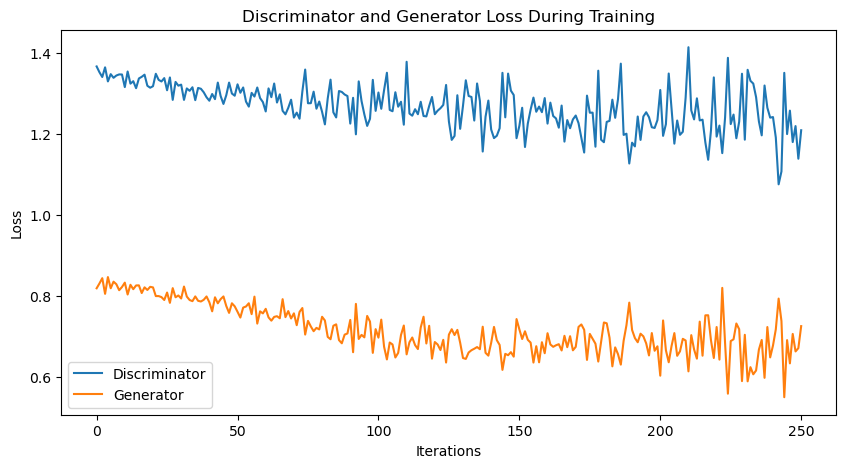

KeyboardInterrupt: 

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import matplotlib.pyplot as plt
from IPython import display

# Assuming other necessary imports and class definitions (Discriminator, Generator, etc.) are already done

device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(device)

# Initialize models
discriminator = Discriminator().to(device)
generator = PatchQuantumGenerator(n_generators).to(device)

# Loss function
criterion = nn.BCELoss()

# Optimizers
optD = optim.SGD(discriminator.parameters(), lr=lrD)
optG = optim.SGD(generator.parameters(), lr=lrG)

# Labels
real_labels = torch.full((batch_size,), 1.0, dtype=torch.float, device=device)
fake_labels = torch.full((batch_size,), 0.0, dtype=torch.float, device=device)

# Fixed noise
fixed_noise = torch.rand(8, n_qubits, device=device) * math.pi / 2

# Loss history
discriminator_loss_values = []
generator_loss_values = []

# Function to update the plot
def plot_losses(d_losses, g_losses):
    display.clear_output(wait=True)
    plt.figure(figsize=(10,5))
    plt.title("Discriminator and Generator Loss During Training")
    plt.plot(d_losses, label="Discriminator")
    plt.plot(g_losses, label="Generator")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Training loop
counter = 0
for epoch in range(num_epochs):
    for i, (data, _) in enumerate(dataloader):
        # ... existing training code ...

        # Data for training the discriminator
        data = data.reshape(-1, image_size * image_size)
        real_data = data.to(device)

        # Noise follwing a uniform distribution in range [0,pi/2)
        noise = torch.rand(batch_size, n_qubits, device=device) * math.pi / 2
        fake_data = generator(noise)

        # Training the discriminator
        discriminator.zero_grad()
        outD_real = discriminator(real_data).view(-1)
        outD_fake = discriminator(fake_data.detach()).view(-1)

        errD_real = criterion(outD_real, real_labels)
        errD_fake = criterion(outD_fake, fake_labels)
        # Propagate gradients
        errD_real.backward()
        errD_fake.backward()

        errD = errD_real + errD_fake
        optD.step()

        # Training the generator
        generator.zero_grad()
        outD_fake = discriminator(fake_data).view(-1)
        errG = criterion(outD_fake, real_labels)
        errG.backward()
        optG.step()
        
        
        
        # Update loss history
        discriminator_loss_values.append(errD.item())
        generator_loss_values.append(errG.item())

        # Print and plot every 10 iterations
        if counter % 10 == 0:
            print(f'Iteration: {counter}, Discriminator Loss: {errD:0.3f}, Generator Loss: {errG:0.3f}')
            plot_losses(discriminator_loss_values, generator_loss_values)

        counter += 1

        if counter == num_iter:
            break
    if counter == num_iter:
        break

# Final plot
plot_losses(discriminator_loss_values, generator_loss_values)


#IF YOU GET THE ERROR THAT FLOAT64 SHOULD BE FLOAT32, DO THIS:
#Modify the  _asarray_torch function in the single_dispatch.py file in the pennylane/math/single_dispatch.py folder corresponding to your environment like this:
#This makes sure that the output of the quantum circuit is a float32 tensor

# def _asarray_torch(x, dtype=None, **kwargs):
#     import torch
#     return torch.as_tensor(x, dtype=torch.float32, **kwargs)


In [54]:
discriminator = Discriminator().to(device)
generator = PatchQuantumGenerator(n_generators).to(device)

# Binary cross entropy
criterion = nn.BCELoss()

# Optimisers
optD = optim.SGD(discriminator.parameters(), lr=lrD)
optG = optim.SGD(generator.parameters(), lr=lrG)

real_labels = torch.full((batch_size,), 1.0, dtype=torch.float, device=device)
fake_labels = torch.full((batch_size,), 0.0, dtype=torch.float, device=device)

# Fixed noise allows us to visually track the generated images throughout training
fixed_noise = torch.rand(8, n_qubits, device=device) * math.pi / 2

# Iteration counter
counter = 0

# Collect images for plotting later
results = []

while True:
    for i, (data, _) in enumerate(dataloader):

        # Data for training the discriminator
        data = data.reshape(-1, image_size * image_size)
        real_data = data.to(device)

        # Noise follwing a uniform distribution in range [0,pi/2)
        noise = torch.rand(batch_size, n_qubits, device=device) * math.pi / 2
        fake_data = generator(noise)

        # Training the discriminator
        discriminator.zero_grad()
        outD_real = discriminator(real_data).view(-1)
        outD_fake = discriminator(fake_data.detach()).view(-1)

        errD_real = criterion(outD_real, real_labels)
        errD_fake = criterion(outD_fake, fake_labels)
        # Propagate gradients
        errD_real.backward()
        errD_fake.backward()

        errD = errD_real + errD_fake
        optD.step()

        # Training the generator
        generator.zero_grad()
        outD_fake = discriminator(fake_data).view(-1)
        errG = criterion(outD_fake, real_labels)
        errG.backward()
        optG.step()

        counter += 1

        # Show loss values
        if counter % 10 == 0:
            print(f'Iteration: {counter}, Discriminator Loss: {errD:0.3f}, Generator Loss: {errG:0.3f}')
            test_images = generator(fixed_noise).view(8,1,image_size,image_size).cpu().detach()

            # Save images every 50 iterations
            if counter % 50 == 0:
                results.append(test_images)

        if counter == num_iter:
            break
    if counter == num_iter:
        break

TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.

In [11]:
fig = plt.figure(figsize=(10, 5))
outer = gridspec.GridSpec(5, 2, wspace=0.1)

for i, images in enumerate(results):
    inner = gridspec.GridSpecFromSubplotSpec(1, images.size(0),
                    subplot_spec=outer[i])

    images = torch.squeeze(images, dim=1)
    for j, im in enumerate(images):

        ax = plt.Subplot(fig, inner[j])
        ax.imshow(im.numpy(), cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
        if j==0:
            ax.set_title(f'Iteration {50+i*50}', loc='left')
        fig.add_subplot(ax)

plt.show()

NameError: name 'results' is not defined

<Figure size 1000x500 with 0 Axes>

In [12]:
#MY OWN ADDED CODE